In [21]:
#import relevant packages 
import pandas as pd 
import numpy as np
# !pip install scipy
# Import requirements 
# from catboost import CatBoostRegressor
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from sklearn.metrics import confusion_matrix,accuracy_score, explained_variance_score, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score,  cross_validate, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import export_graphviz
from xgboost import plot_importance, plot_tree
import itertools

import matplotlib.pyplot as plt # we only need pyplot
import numpy as np
import pandas as pd
import seaborn as sb
import xgboost as xgb

sb.set() # set the default Seaborn style for graphics

In [22]:
import plotly.graph_objects as go
import plotly.express as px
import scipy.stats as stats
from IPython.display import display, HTML

In [23]:
df = pd.read_csv('listing.csv')

In [24]:
# Function to create scrollable table within a small window
def create_scrollable_table(df, table_id, title):
    html = f'<h3>{title}</h3>'
    html += f'<div id="{table_id}" style="height:200px; overflow:auto;">'
    html += df.to_html()
    html += '</div>'
    return html

In [71]:
df.shape

(988, 20)

In [25]:
def remove_rows_with_missing_ratings(df):
       
       df = df.dropna(subset=['Location_rating'])
       return  df

df = remove_rows_with_missing_ratings(df)

In [26]:
def combine_description_strings(df):

        df['Description'].str.replace("'About this space',","")
        df['Description'] = df['Description'].str.replace('"',"")
        df['Description'] = df['Description'].str.replace("' '","")
        df['Description'] = df['Description'].str.replace("'","")
        df['Description'] = df['Description'].str.replace(r'\\n', '')
        df['Description'] = df['Description'].str.replace(r'\\n\\', '')
        df['Description'] = df['Description'].str.split(',', n=1).str[-1]
        df['Description'] = df['Description'].str[:-2]
        df= df.dropna(subset=['Description'])
        return df
df = combine_description_strings(df)

In [27]:
def set_default_feature_values(df):

        df['beds'] = df['beds'].fillna(1)
        df['guests'] = df['guests'].fillna(1)
        df['bathrooms'] = df['bathrooms'].fillna(1)
        df['bedrooms'] = df['bedrooms'].fillna(1)
        return df
    
def clean_tabular_data(df):
    df = set_default_feature_values(df)
    df = remove_rows_with_missing_ratings(df)
    df = combine_description_strings(df)
    try:
        df.drop('Unnamed: 19', axis=1, inplace=True)
    except:
        pass
    return df


df = set_default_feature_values(df)
df = clean_tabular_data(df)


In [28]:
numerical_features = df.select_dtypes(include=[np.number])
numerical_features.describe()

,beds,bathrooms,Price_Night,Cleanliness_rating,Accuracy_rating,Communication_rating,Location_rating,Check-in_rating,Value_rating,amenities_count
count,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000,830.000000
mean,2.425301,1.376506,153.934940,5.088916,4.905904,4.933494,4.905060,4.944458,4.769277,35.451446
std,1.844651,0.827813,129.179626,6.776068,0.130051,0.121753,0.120707,0.104018,0.174995,14.256733
min,1.000000,0.000000,3.000000,3.800000,4.000000,3.900000,4.000000,3.900000,3.700000,3.000000
25%,1.000000,1.000000,83.000000,4.800000,4.900000,4.900000,4.900000,4.900000,4.700000,25.000000
50%,2.000000,1.000000,120.000000,4.900000,4.900000,5.000000,4.900000,5.000000,4.800000,35.000000
75%,3.000000,1.500000,176.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.900000,44.000000
max,17.000000,10.000000,1132.000000,200.000000,5.000000,5.000000,5.000000,5.000000,5.000000,84.000000


In [29]:
# Summary statistics for numerical dataf
numerical_data = df.select_dtypes(include=[np.number])
summary_stats = numerical_data.describe().T
html_numerical = create_scrollable_table(summary_stats, 'numerical_data', 'Summary statistics for numerical data')

display(HTML(html_numerical))

,count,mean,std,min,25%,50%,75%,max
beds,830.0,2.425301,1.844651,1.0,1.0,2.0,3.0,17.0
bathrooms,830.0,1.376506,0.827813,0.0,1.0,1.0,1.5,10.0
Price_Night,830.0,153.934940,129.179626,3.0,83.0,120.0,176.0,1132.0
Cleanliness_rating,830.0,5.088916,6.776068,3.8,4.8,4.9,5.0,200.0
Accuracy_rating,830.0,4.905904,0.130051,4.0,4.9,4.9,5.0,5.0
Communication_rating,830.0,4.933494,0.121753,3.9,4.9,5.0,5.0,5.0
Location_rating,830.0,4.905060,0.120707,4.0,4.9,4.9,5.0,5.0
Check-in_rating,830.0,4.944458,0.104018,3.9,4.9,5.0,5.0,5.0
Value_rating,830.0,4.769277,0.174995,3.7,4.7,4.8,4.9,5.0
amenities_count,830.0,35.451446,14.256733,3.0,25.0,35.0,44.0,84.0


First, we model based on numerical data.
We will create a features array that contains all the columns that are numerical.

Then we extract the price per night as the label array for predictions/tests.

In [30]:
# Separate the features (input) and labels (output)
features = numerical_data.drop('Price_Night', axis=1)  # Exclude the 'Price_Night' column as the label
labels = numerical_data['Price_Night']

# Return the features and labels as a tuple
features_labels_tuple = (features, labels)


**Stage 3: Modelling and Prediction**
Data is ready for the training of models

We will use scikit-learn modules to perform our modelling.

The goal is to generate models that will best predict the price per night based on which features the model deems to be of high importance/influence.

In [31]:
# Differentiation of features and labels
X = features
y = labels
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = list(X.columns))
# Splitting into train and test sets
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42 )

In [32]:
null_values = df.isnull().sum()
html_null_values = create_scrollable_table(null_values.to_frame(), 'null_values', 'Null values in the dataset')

# Percentage of missing values for each feature
missing_percentage = (df.isnull().sum() / len(df)) * 100
html_missing_percentage = create_scrollable_table(missing_percentage.to_frame(), 'missing_percentage', 'Percentage of missing values for each feature')

display(HTML(html_null_values + html_missing_percentage))

,0
ID,0
Category,0
Title,0
Description,0
Amenities,0
Location,0
guests,0
beds,0
bathrooms,0
Price_Night,0


**Supervised Machine Learning Models**
Model 1 - Linear Regression

A simple model based on an equation of Regression Problem : Price = a * (Predictor Variables) + b

In [33]:
# Creating and fitting the model
model= LinearRegression()
model.fit(X_train, y_train)
print('Intercept of Regression \t: b  = ', model.intercept_)



Intercept of Regression 	: b  =  153.2855121913216


In [35]:
# Predict Response corresponding to Predictors
# Make predictions on the test data
y_pred = model.predict(X_test)
train_pred = model.predict(X_train)


# Compute RMSE for training and test sets
rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

# Compute R^2 for training and test sets
r2_train = r2_score(y_train, train_pred)
r2_test = r2_score(y_test, y_pred)

# Print the performance measures
print("RMSE - Training set:", rmse_train)
print("RMSE - Test set:", rmse_test)
print("R^2 - Training set:", r2_train)
print("R^2 - Test set:", r2_test)



# Evaluate the model
mse = mean_squared_error(y_test, y_pred)


# Print the evaluation metrics
print("Mean Squared Error test set:", mse)




RMSE - Training set: 101.32260787150916
RMSE - Test set: 108.15972971500096
R^2 - Training set: 0.35761566914283993
R^2 - Test set: 0.39235477272030017
Mean Squared Error test set: 11698.527132022064


Text(0, 0.5, 'Predicted values of the Response Variable (Test)')

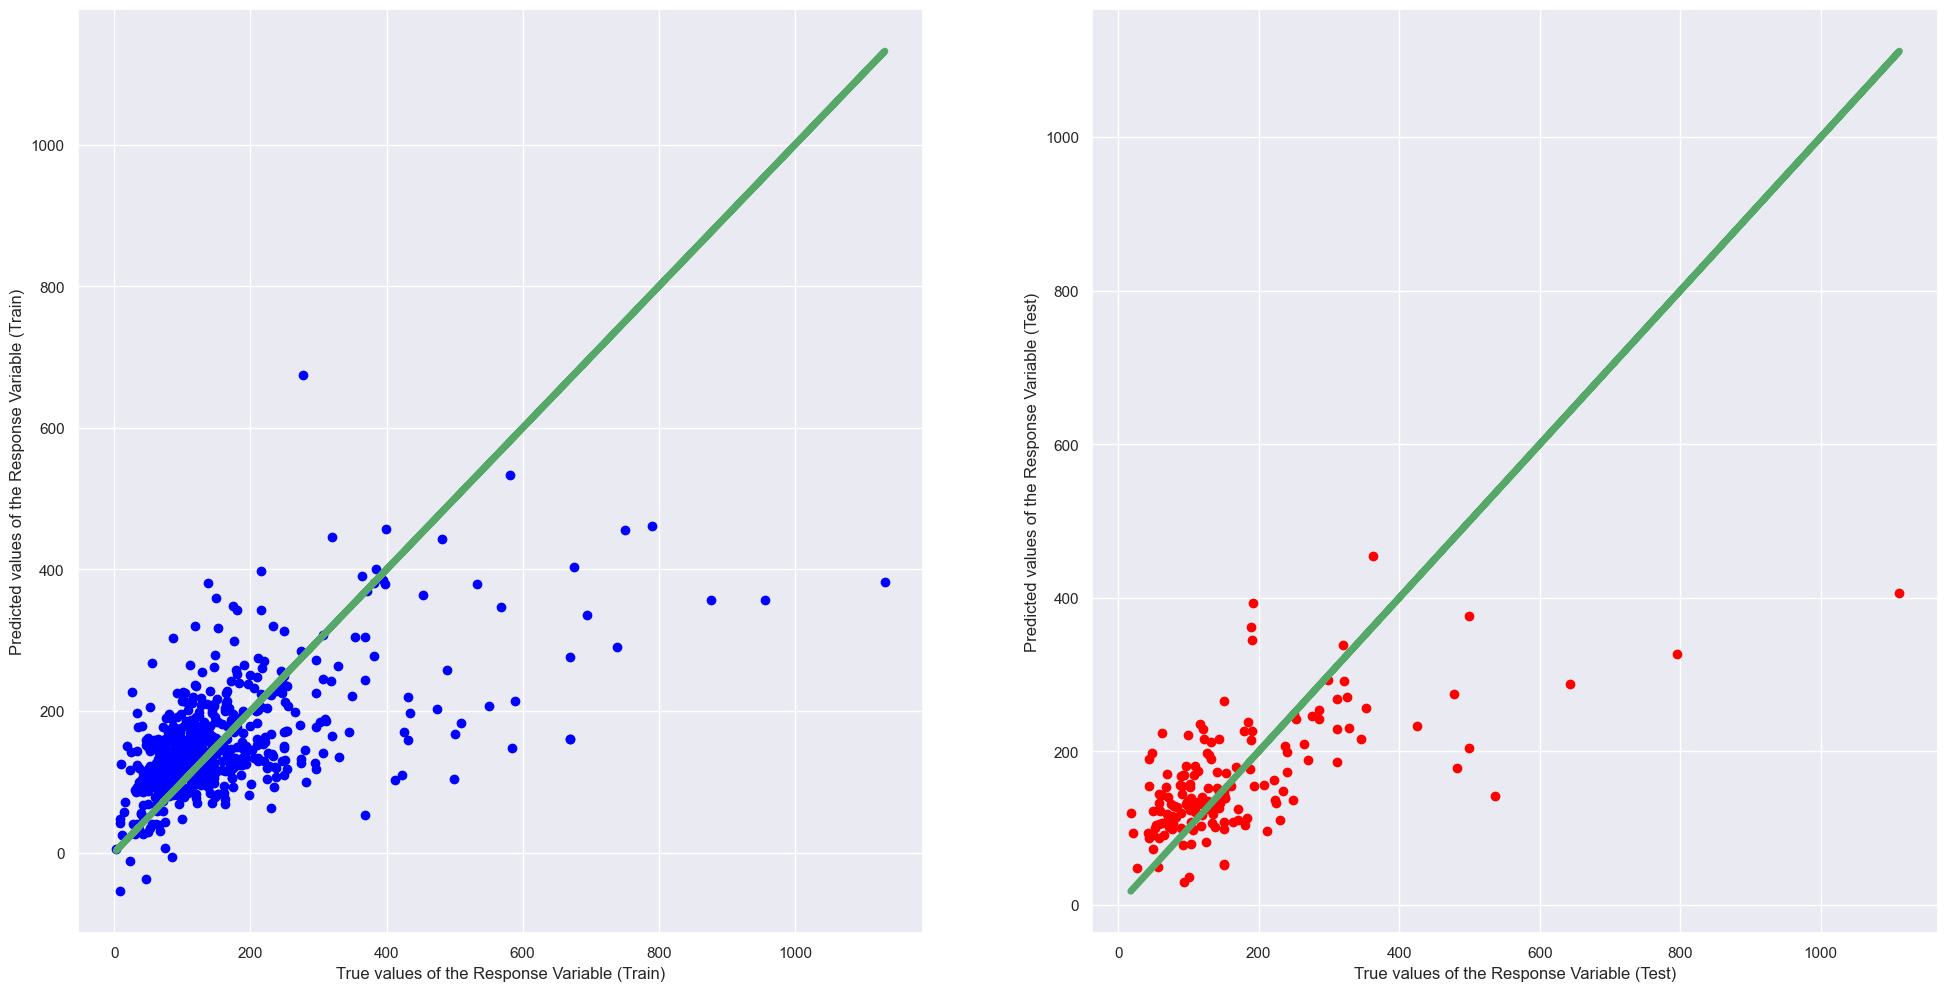

In [36]:
# Plot the Predictions vs the True values
f, axes = plt.subplots(1, 2, figsize=(24, 12))
axes[0].scatter(y_train, train_pred, color = "blue")
axes[0].plot(y_train, y_train, 'g-', linewidth = 5)
axes[0].set_xlabel("True values of the Response Variable (Train)")
axes[0].set_ylabel("Predicted values of the Response Variable (Train)")
axes[1].scatter(y_test, y_pred, color = "red")
axes[1].plot(y_test, y_test, 'g-', linewidth = 5)
axes[1].set_xlabel("True values of the Response Variable (Test)")
axes[1].set_ylabel("Predicted values of the Response Variable (Test)")

In [54]:
def custom_tune_regression_model_hyperparameters(model, grid_dic, data):
    """manual application: performs a grid search over a reasonable range of hyperparameter values

    Args:
        model_type: model class
        grid_dic (dict): A dictionary of hyperparameter names mapping to a list of values to be tried
        data_sets (list): The training, validation, and test sets

    Returns:
        return the best model, a dictionary of its best hyperparameter values, and a dictionary of its performance metrics._
    """
    
    best_mse = float('inf')
    
    best_hyperparameters = {}

    # Iterate over each combination of hyperparameter values
    for param_values in itertools.product(*grid_dic.values()):
        params = dict(zip(grid_dic.keys(), param_values))

        # Create a linear regression model with the current hyperparameter values
        model_type = model(**params)

        # Fit the model on the training data
        model_type.fit(data[0], data[2])

        # Predict on the validation data
        y_pred = model_type.predict(data[1])

        # Calculate the mean squared error
        mse = mean_squared_error(data[3], y_pred)

        # Check if the current hyperparameters result in a better MSE
        if mse < best_mse:
            best_mse = mse
            best_hyperparameters = params

    # Print the best hyperparameters and MSE
    print("Best Hyperparameters:", best_hyperparameters)
    print("Best MSE:", best_mse)


grid_dic =  {'alpha':[0.001,0.01,0.1,1],
              'max_iter':[1000,5000,10000,50000],
              'tol':[0.1,0.01,0.001,0.001]}
data = X_train, X_test, y_train, y_test
custom_tune_regression_model_hyperparameters(Lasso, grid_dic, data)

Best Hyperparameters: {'alpha': 1, 'max_iter': 1000, 'tol': 0.1}
Best MSE: 11651.177778670162
